In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
from src.log import logger
logger.setLevel(logging.INFO)

### Paths

In [1]:
from src.paths import interim_data_path, external_data_path

List available the files processed using the Matlab script. 

In [6]:
from src.utils import list_dir

list_dir(external_data_path / 'mbi-cle')

['mbi-cle.readme',
 'DMPSmbiocle2019.dat',
 'DMPSmbiocle2015.dat',
 'DMPSmbiocle2018.dat',
 'DMPSmbiocle2014.dat',
 'DMPSmbiocle2020.dat',
 'DMPSmbiocle2016.dat',
 'DMPSmbiocle2013.dat',
 'mbi-cle.license',
 'DMPSmbiocle2017.dat']

## Reading the data

Create a function to read clean ```.cle``` or ```.dat``` files.

In [61]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


def read_cle_file(filename, has_flag=True, col_names=None, utc_time=True, resample_freq='10T', **kwargs):
    """Read a DMPS inverted .cle file
    
    Data is multiple space-delimited. The file contains processed particle number size 
    distributions with the original time resolution of the instrument.
    
    Parameters
    ----------
    filename: path-like

    has_flag: boolean
        if true, last column is treated as a flag
    col_names: arry-like, optional
        list of column names to use. Duplicates in this list are not allowed.
    resample_freq: str
        pandas-like frequency string


    Returns
    -------
    data: DataFrame
    """

    year = int(filename.stem[-4:])

    df = pd.read_csv(filename, delim_whitespace=True)

    if col_names is None:
        df.columns.values[0] = 'datetime'
        df.columns.values[1] = 'tot_conc'

        if has_flag:
            df.columns.values[-1] = 'flag'
    else:
        df.columns = col_names

    # Convert decimal day of year to datetime column to dataframe index
    df['datetime'] = df['datetime'].apply(lambda ddoy: datetime(year - 1, 12, 31) + timedelta(days=ddoy))
    df.set_index('datetime', inplace=True)

    if resample_freq is not None:
        df = df.resample(resample_freq).mean()

    tot_conc = df['tot_conc']

    df.drop('tot_conc', axis=1, inplace=True)

    flags = df['flag']

    # Remove data with flag different than '0'
    df.loc[flags == 1] = np.nan
    df.loc[flags == 2] = np.nan
    df.loc[flags == 3] = np.nan
    df.loc[flags == 4] = np.nan

    df.drop('flag', axis=1, inplace=True)

    # Convert column names (dp_peak in nm) to floats.
    df.columns = [float(i) * 1e9 for i in df.columns]

    if not utc_time:
        df.index = df.index - timedelta(hours=3)
        # df.index = df.index.tz_localize(tz='UTC').tz_convert(tz='America/Argentina/Buenos_Aires')

    return df, flags

Reading a data file with the flags

In [62]:
data, flags = read_cle_file(external_data_path / 'mbi-cle' / 'DMPSmbiocle2016.dat')

Plot all the data

/home/gfogwil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


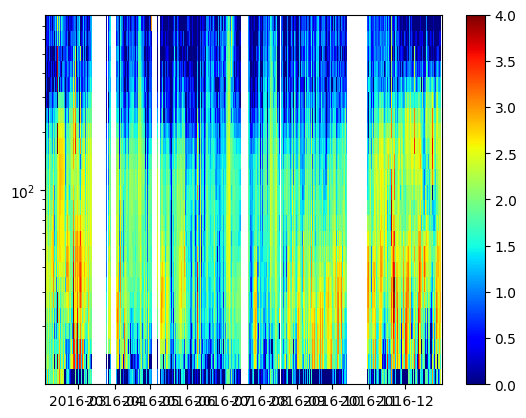

In [63]:
import numpy as np
import matplotlib.pyplot as plt

plt.pcolor(data.index, data.columns, np.log10(abs(data.values[::1, ::1].T)+1e-6) , cmap='jet')
plt.colorbar()
plt.clim(0, 4)

plt.yscale('log')
plt.show()

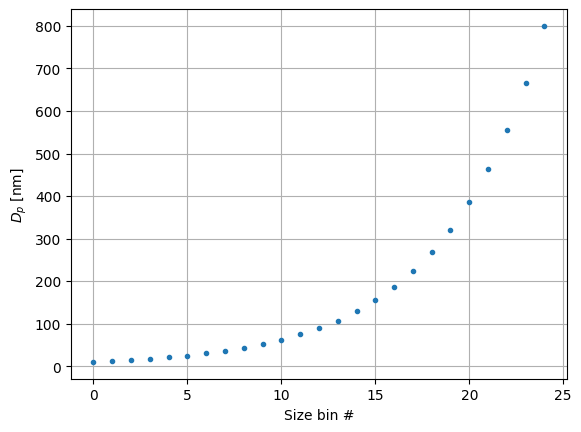

In [42]:
plt.plot(X.columns, '.')

plt.xlabel('Size bin #')
plt.ylabel('$D_p$ [nm]')
# plt.yscale('log')
plt.grid()
plt.show()

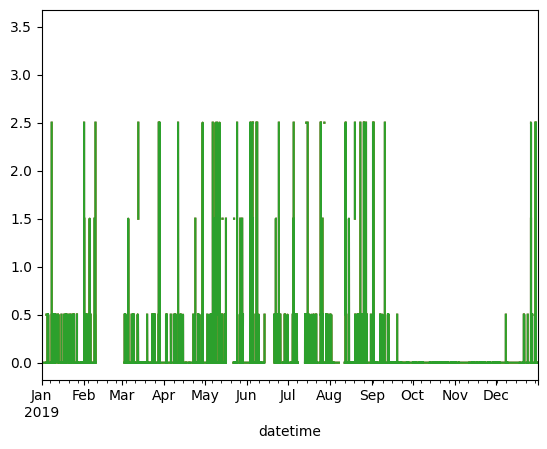

In [17]:
import matplotlib.pyplot as plt
y.plot()
plt.show()